### Login to our application

We log in to WandB to perform the optimization of the different hyperparameters available in our genetic algorithm.

In [4]:
import random
import numpy as np
import copy
import time
import wandb

wandb.login() #to execute this cell it is necessary to use a valid wandb token
#from one of the members of the project created in the application to solve this academic work.

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hmarcab (opt). Use `wandb login --relogin` to force relogin


Below we show the hyperparameters and their possible values with which we are going to work in this project:

In [5]:
#hiperparámetros to optimyze (with its possible values)

soluciones_aleatorias = ['simple','ponderada']
t_poblacion_inicial = [50, 100, 200, 300, 400, 500, 1000] #initial population size
p_poblacion_elite = [0.1, 0.25, 0.3, 0.4] #elite population percentage
seleccion = ['completa', 'subelite'] #whether the second parent is drawn from the entire population or from the subelite population
operador_cruce = ['sesgado','ac','as', 'au'] #crossover operator
p_elite = [0.6,0.7,0.8] #weight given to the hereditary material from the father of the elite population
operador_mutacion = ['simple','hl'] #mutation operator
p_mutacion = [0.1,0.2,0.3,0.5,0.7] #mutation probability

### GA class adapted to run executions with different hyperparameters

The modification we have made is to add a seed to the functions where the initial populations are created in order to be able to replicate the population in the executions of the same repetition.

In [6]:
class GA:

    def read_problem_instance(self,problem_path): 
        """
        TODO: Implementar método para leer una instancia del problema
        y ajustar los atributos internos del objeto necesarios
        """
        apuestas=[]
        with open(problem_path,'r') as file:
            
            for linea in file:
                lista=linea.split()
                if len(lista)>0:
                    if lista[0]=='goods':

                        bienes=int(lista[1])

                    elif lista[0]=='bids':

                        n_apuestas=int(lista[1])

                    else:
                        
                        apuestas.append((float(lista[1]),set(lista[2:-1])))
        
        return bienes, n_apuestas, apuestas
    
    def create_random_solution(self): 
        
        return [random.random() for i in range(self.n_apuestas)]

    def create_ponderate_solution(self): 
        
        return [random.random()*len(self.apuestas[i][1])/self.apuestas[i][0] for i in range(self.n_apuestas)]
    
    def create_random_population(self): 
        random.seed(132)
        return [self.create_random_solution() for i in range(self.tamano_poblacion_inicial)] if self.sol=='simple' else [self.create_ponderate_solution() for i in range(self.tamano_poblacion_inicial)]
    
    def get_fitness(self, solucion):

        
        vendidos=set() 
        fitness=0 
        
        for i in np.argsort(solucion): 
            
            ap=self.apuestas[i] 

            if len(vendidos.intersection(ap[1]))==0: 
                fitness+=ap[0] 
                vendidos=vendidos.union(ap[1]) 
                
            
        return fitness 
        
    
    def get_fitness_and_vec(self, solucion): 

        vendidos=set() 
        fitness=0 
        vector_binario=[] 
        
        for i in np.argsort(solucion): 
            
            ap=self.apuestas[i] 

            if len(vendidos.intersection(ap[1]))==0: #
                fitness+=ap[0] 
                vendidos=vendidos.union(ap[1]) 
                vector_binario.append(i)  
        return fitness,vector_binario 
                    
    def get_best_solution(self): 
        """
        Método para devolver la mejor solución encontrada hasta
        el momento
        """
        #TODO
        return self.best_solution, self.binary_vector
    



    def simple_swap(self,individual):
      #TODO
        hijo=copy.copy(individual)
        p1=random.randint(0,len(individual)-2)
        p2=random.randint(p1,len(individual)-1)
        hijo[p1],hijo[p2]=hijo[p2],hijo[p1]
        return hijo

    def high_low_swap(self,individual):
        hijo=copy.copy(individual)
        m = len(hijo)//2
        indexes = np.argsort(hijo)
        p1, p2 = random.choice(indexes[:m]), random.choice(indexes[m:]) 
        hijo[p1],hijo[p2]=hijo[p2],hijo[p1]
        return hijo
    

    def cruce_sesgado(self,individual1, individual2,p_elite):

        hijo = []
        
        for i in range(len(individual1)):
            
            p=random.random()
            
            if p<p_elite:
                
                hijo.append(individual1[i])
            else:
                hijo.append(individual2[i])
        
        
        return hijo

        

    def cruce_recombinacion_arit_completa(self, individual1, individual2, p_elite): 
      hijo = []

      for i in range(len(individual1)): 

        hijo.append(p_elite*individual1[i]+(1-p_elite)*individual2[i]) 
                                                                  
      
      return hijo

    

    def aritmetica_simple(self, individual1, individual2, prob_elite):
    
      hijo = []
      p_corte = random.randint(1,len(individual1)-1)
      hijo = individual1[0:p_corte]
      
      for i in range (p_corte, len(individual1)):
          hijo.append(prob_elite*individual1[i] + (1-prob_elite)*individual2[i])
          
      return hijo

    

    def aritmetica_unica(self, individual1, individual2, prob_elite):
        
        hijo = copy.copy(individual1)
        p_corte = random.randint(1,len(individual1)-1)
        
        hijo[p_corte] = prob_elite*individual1[p_corte] + (1-prob_elite)*individual2[p_corte]
                                
        return hijo

    
    



    def select_best_n(self,population, n): 

     
        sorted_population= sorted(population,key= lambda sol: self.get_fitness(sol),reverse=True)
        return sorted_population[:n], sorted_population[n:]


    def run(self):
        """
        Método que ejecuta el algoritmo genético. Debe crear la población inicial y
        ejecutar el bucle principal del algoritmo genético
        TODO: Se debe implementar aquí la lógica del algoritmo genético
        """
        time_ini = time.time() 
        
        generaciones_cambiando=0
        
        time_fin =time.time()
      
            
        poblacion = self.create_random_population() 
            
        while generaciones_cambiando < 100 and time_fin-time_ini<self.time_deadline: 
                
              p_elite, p_sub_elite = self.select_best_n(poblacion, self.tamano_elite) 

              next_poblacion = copy.copy(p_elite) 
                
              n_mutantes = random.randint(1,self.tamano_poblacion_inicial//2) 
              if self.sol =='simple':
                for i in range(n_mutantes):

                    next_poblacion.append(self.create_random_solution())
              else:
                  for i in range(n_mutantes):

                    next_poblacion.append(self.create_ponderate_solution())


                
              for i in range(self.tamano_poblacion_inicial-len(next_poblacion)): 

                  p1 = random.choice(p_elite) 

                  if self.operador_seleccion=='completa':
                    p2 = random.choice(poblacion) 
                  
                  elif self.operador_seleccion=='subelite':
                    p2 = random.choice(p_sub_elite) 
                  
                  else:

                    print('Error,operador de selección no válido')
                    break

                  if self.operador_cruce == 'sesgado':
                    hijo = self.cruce_sesgado(p1,p2,self.p_elite) 

                  elif self.operador_cruce == 'ac':
                    hijo = self.cruce_recombinacion_arit_completa(p1,p2,self.p_elite)

                  elif self.operador_cruce == 'as':
                    hijo = self.aritmetica_simple(p1,p2,self.p_elite)
                  
                  elif self.operador_cruce == 'au':
                    hijo = self.aritmetica_unica(p1,p2,self.p_elite)

                  else:
                    print('Error, operador de cruce no válido')
                    break
                    
                  if random.random()<self.p_mutacion: 
                      
                      if self.operador_mutacion=='simple':
                        hijo = self.simple_swap(hijo)
                      elif self.operador_mutacion=='hl':
                        hijo = self.high_low_swap(hijo)
                      else:
                        print('Error, operador de mutación no válido')
                        break
                        
                  next_poblacion.append(hijo) 

              poblacion= copy.copy(next_poblacion) 

              mejor, resto = self.select_best_n(poblacion, 1) 
                
              punt, rpr = self.get_fitness_and_vec(mejor[0]) 
                
              if punt > self.best_solution: 
                  print('Mejor solución encontrada')
                  self.tiempo_mejor_sol=time.time()-time_ini
                  self.best_solution=punt 
                  self.binary_vector=rpr
                  generaciones_cambiando=0
              else: 
                  generaciones_cambiando+=1 

              time_fin=time.time()      

            

    def __init__(self,time_deadline=180,problem_path='p01.txt',tamano_poblacion_inicial=100,operador_cruce='sesgado', p_elite=0.6, 
                 operador_mutacion='hl',p_mutacion=0.2, operador_seleccion='subelite', tamano_elite=0.3, sol='simple'):
        
        """
        Inicializador de los objetos de la clase. Usar
        este método para hacer todo el trabajo previo y necesario
        para configurar el algoritmo genético
        Args:
            problem_path: Cadena de texto que determina la ruta en la que se encuentra la definición del problema
            time_deadline: Límite de tiempo que el algoritmo genético puede computar
        """

        self.tamano_poblacion_inicial=tamano_poblacion_inicial #
        
        self.n_bienes,self.n_apuestas,self.apuestas=self.read_problem_instance(problem_path) #
        
        self.best_solution = 0 
        
        self.binary_vector = None 
        
        self.tiempo_mejor_sol = None 
        
        self.time_deadline = time_deadline 
        
        self.operador_cruce = operador_cruce 
        
        self.p_elite = p_elite 
        
        self.operador_mutacion = operador_mutacion 
        
        self.p_mutacion = p_mutacion 
        
        self.operador_seleccion = operador_seleccion 
        self.tamano_elite = int(round(tamano_poblacion_inicial*tamano_elite,0))

        self.sol = sol 


        #TODO: Completar método para configurar el algoritmo genético (e.g., seleccionar cruce, mutación, etc.)


### Loop for launching runs of the genetic algorithm

Each time we run the next cell, we perform a Bayesian hyperparameter tuning through the WandB framework. The hyperparameters 'Initial population size' and 'File' remain constant in each run, so we ensure that the initial population ensured is the same in the same repetition and we ensure that the same runs are executed with each file. Thus, for each population size we perform 100 runs with each instance, for a total of 800 runs with each value of the initial population size hyperparameter. The results are automatically stored in the WandB framework for further analysis. Each time we run the next cell, it is corrected with a repetition with a fixed population size and a fixed problem instance of 100 runs with different configurations, in this way the process can be parallelized and each user can perform repetitions from his machine, and the results will be stored in the WandB framework.

In [ ]:


# Define sweep config, to maximize score and minimize time
sweep_configuration = {
    'method': 'bayes', #search method between grid, random and bayes search
    'metric': {
        'name': 'score', #we call the metric to optimize score
        'goal': 'maximize' #we have a maxiimzation problem
    },
    'parameters': { #we define the parameters to sweep
        'soluciones_aleatorias': {'values':['simple','ponderada']},
        't_poblacion_inicial': {'values':[50,150,300,500]}, #select only one value in each execution
        'fichero': {'values':['P01.txt','P02.txt','P03.txt','P04.txt','hard-0.txt','hard-1.txt','hard-2.txt']}, #select only one value in each execution
        'p_poblacion_elite': {'values':[0.1,0.25,0.3,0.4]},
        'seleccion': {'values':['subelite','completa']},
        'operador_cruce': {'values':['sesgado','ac','as','au']},
        'p_elite': {'values':[0.6,0.7,0.8]},
        'operador_mutacion': {'values':['hl','simple']},
        'p_mutacion': {'values':[0.05,0.15,0.3]}
        },
    'run_cap':100 #nº of runs in each repetition

}   

# Create sweep / Select project where we want to save the results
sweep_id = wandb.sweep(sweep_configuration, entity='opt',project="Experimentación AG")

# Define sweep agent
def sweep_agent():
    # Initialize a new wandb run
    wandb.init()

    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Create a new instance of the model, initialized with the hyperparameters we are sweeping over
    alg = GA(180,config.fichero,config.t_poblacion_inicial,config.operador_cruce,config.p_elite,config.operador_mutacion,config.p_mutacion,config.seleccion,config.p_poblacion_elite,config.soluciones_aleatorias)
    
    # Train the model and save metrics
    alg.run()
    score = alg.best_solution
    wandb.log({"score": score})

# Execute sweep agent
wandb.agent(sweep_id, function=sweep_agent)

### Standardization of results

Once we have all the runs of all the repetitions, we proceed to normalize the results of each file (subtracting its mean and dividing by its standard deviation) in order to compare the results of all of them. In the next cell we process the data to obtain the fitness of each normalized run.

In [9]:
import pandas as pd
df = pd.read_csv('resultados_exp.csv')
print(df.shape)
#pivot wider columns dataframe
df = df.pivot(index=['ID','Name','User','Runtime','t_poblacion_inicial','soluciones_aleatorias','p_poblacion_elite','seleccion','operador_cruce','p_elite','operador_mutacion','p_mutacion'], columns='fichero', values='score').reset_index()
print(df.shape)
#standarize columns  (gl-gl.mean()) / gl.std()


df['hard-1.txt'] = (df['hard-1.txt'] - df['hard-1.txt'].mean()) / df['hard-1.txt'].std()
df['hard-2.txt'] = (df['hard-2.txt'] - df['hard-2.txt'].mean()) / df['hard-2.txt'].std()
df['hard-0.txt'] = (df['hard-0.txt'] - df['hard-0.txt'].mean()) / df['hard-0.txt'].std()
df['P00.txt'] = (df['P00.txt'] - df['P00.txt'].mean()) / df['P00.txt'].std()
df['P01.txt'] = (df['P01.txt'] - df['P01.txt'].mean()) / df['P01.txt'].std()
df['P02.txt'] = (df['P02.txt'] - df['P02.txt'].mean()) / df['P02.txt'].std()
df['P03.txt'] = (df['P03.txt'] - df['P03.txt'].mean()) / df['P03.txt'].std()
df['P04.txt'] = (df['P04.txt'] - df['P04.txt'].mean()) / df['P04.txt'].std()

#pivot longer columns dataframe
df = pd.melt(df, id_vars=['ID','Name','User','Runtime','t_poblacion_inicial','soluciones_aleatorias','p_poblacion_elite','seleccion','operador_cruce','p_elite','operador_mutacion','p_mutacion'], value_vars=['hard-1.txt','hard-2.txt','hard-0.txt','P00.txt','P01.txt','P02.txt','P03.txt','P04.txt'], var_name='fichero', value_name='score')
#eliminate Na values
df = df.dropna(subset=['score'])
print(df.shape)
df.head()


(3237, 14)
(3237, 20)
(3237, 14)


,ID,Name,User,Runtime,t_poblacion_inicial,soluciones_aleatorias,p_poblacion_elite,seleccion,operador_cruce,p_elite,operador_mutacion,p_mutacion,fichero,score
8,02l4ztxt,amber-sweep-97,oslubla,125,150,ponderada,0.25,subelite,sesgado,0.6,hl,0.30,hard-1.txt,0.608019
23,09o6j2at,mild-sweep-72,hmarcab,155,300,simple,0.10,completa,sesgado,0.6,hl,0.30,hard-1.txt,0.270002
26,0avc7asx,jumping-sweep-88,hmarcab,187,300,simple,0.40,completa,sesgado,0.6,simple,0.30,hard-1.txt,0.484163
36,0hs3v1p4,swept-sweep-54,oslubla,87,150,ponderada,0.10,completa,sesgado,0.7,hl,0.30,hard-1.txt,0.466754
37,0idm8scz,lucky-sweep-99,hmarcab,216,300,simple,0.25,subelite,sesgado,0.6,simple,0.15,hard-1.txt,0.608019


In [3]:
#save the results in a csv file
df.to_csv('resultados_exp_norm.csv', index=False,sep=';')

With this file we can now perform the significance tests to determine which combination of hyperparameters works best with our problem instances. To do this, we have selected the 6 configurations with the best average fitness and we have performed 2 runs with each available instance (8 files with problem instances) for each configuration. This gives us a total of 16 runs with each of the 6 configurations, with which we will perform the appropriate tests to determine which is the best configuration for our genetics.

### Configuration selection process

The aim of this task is to test whether the difference in medians between the hyperparameter configurations is statistically significant.

First, we upload the executions of the 6 configurations we are testing:

In [2]:
import pandas as pd

df = pd.read_excel("resultados_exp_norm.xlsx",sheet_name='resultados_filtrados')
print(df.shape)
df.head()

(96, 16)


,ID,Name,User,Runtime,t_poblacion_inicial,soluciones_aleatorias,p_poblacion_elite,seleccion,operador_cruce,p_elite,operador_mutacion,p_mutacion,fichero,union,CONFIGURACION,SCORE
0,4v2crxxv,solar-sweep-6,hmarcab,167,150,ponderada,0.1,completa,sesgado,0.8,hl,0.15,"hard-1,txt","150ponderada0,1completasesgado0,8hl0,15",conf1,-1.223439
1,zpuyw5km,ethereal-sweep-6,jguimar,118,150,ponderada,0.1,completa,sesgado,0.8,hl,0.15,"hard-1,txt","150ponderada0,1completasesgado0,8hl0,15",conf1,-0.150806
2,l844bbma,eternal-sweep-7,hmarcab,97,150,ponderada,0.1,completa,sesgado,0.8,hl,0.15,"hard-2,txt","150ponderada0,1completasesgado0,8hl0,15",conf1,-0.175106
3,nruq3ps8,solar-sweep-7,jguimar,61,150,ponderada,0.1,completa,sesgado,0.8,hl,0.15,"hard-2,txt","150ponderada0,1completasesgado0,8hl0,15",conf1,-0.879574
4,xirwpo6b,scarlet-sweep-5,hmarcab,102,150,ponderada,0.1,completa,sesgado,0.8,hl,0.15,"hard-0,txt","150ponderada0,1completasesgado0,8hl0,15",conf1,-1.350716


### Exploratory data analysis

Initially, an exploratory analysis is carried out using a boxplot to determine the distribution of the best configurations and to be able to compare the medians.

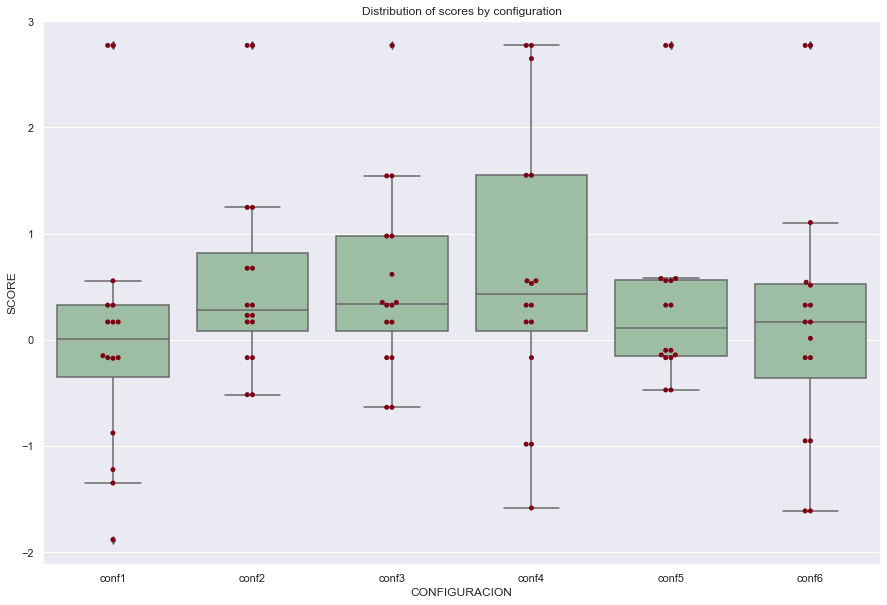

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15,10)})

ax = sns.boxplot(x='CONFIGURACION', y='SCORE', data=df,
                 color='#99c2a2').set(title='Distribution of scores by configuration')
ax = sns.swarmplot(x="CONFIGURACION", y="SCORE", data=df, 
                 color='#7d0013').set(title='Distribution of scores by configuration')
plt.show()

The graph shows that the distribution of the best configurations is similar, so we cannot select a configuration yet. Next, we will compare the runtime of the configurations to see which one is the fastest.

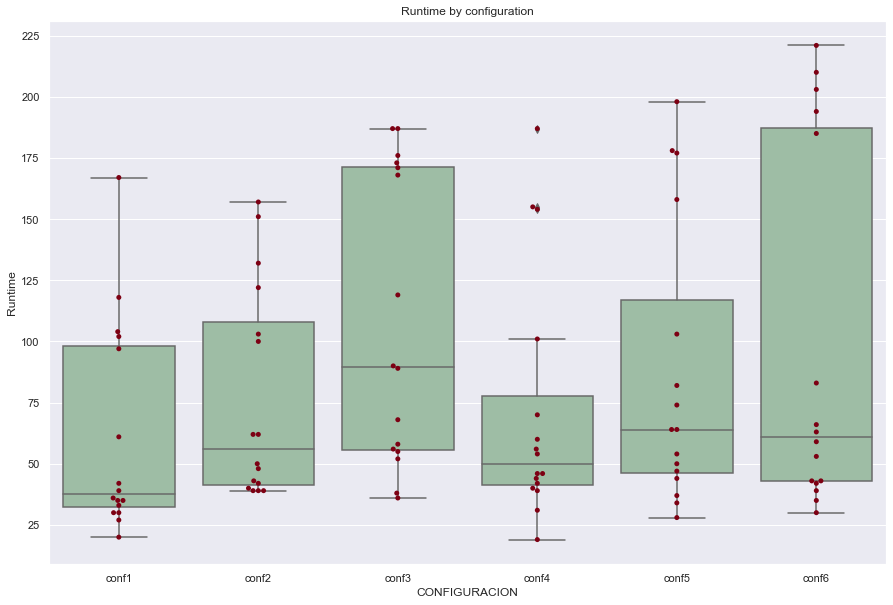

In [7]:
sns.set(rc={'figure.figsize':(15,10)})

ax = sns.boxplot(x='CONFIGURACION', y='Runtime', data=df, 
                 color='#99c2a2').set(title='Runtime by configuration')
ax = sns.swarmplot(x="CONFIGURACION", y="Runtime", data=df, 
                 color='#7d0013').set(title='Runtime by configuration')
plt.show()

The median runtime is not very different between the configurations, however, it is clear that its variance is. Conf4 has the lowest variance among the configurations, making it the most stable. However, there is a trade-off between score and runtime, so a significance test will be performed to see if the difference in medians is statistically significant.

### Normality test

To perform the significance test, it is necessary that the samples follow a normal distribution. To check this, a qqplot of the samples is performed.

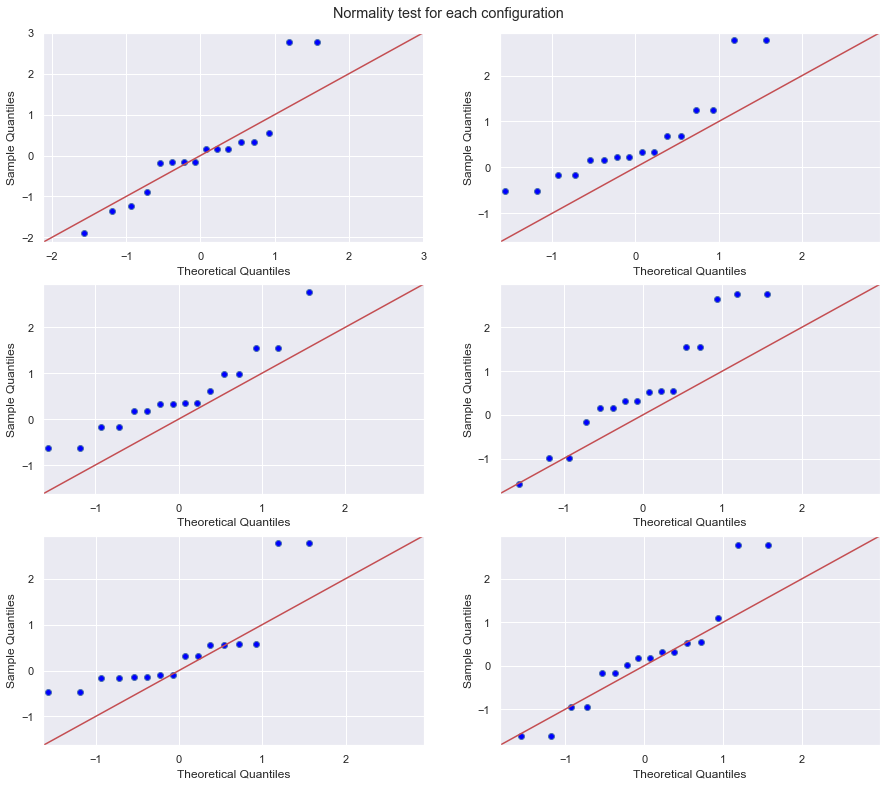

In [9]:
import statsmodels.api as sm
import pylab
sns.set(rc={'figure.figsize':(15,12)})
fig, ax = plt.subplots(nrows=3,ncols=2)

ax1=sm.qqplot(df['SCORE'][df['CONFIGURACION']=='conf1'], line='45',ax=ax[0,0])
ax1=sm.qqplot(df['SCORE'][df['CONFIGURACION']=='conf2'], line='45',ax=ax[0,1])
ax1=sm.qqplot(df['SCORE'][df['CONFIGURACION']=='conf3'], line='45',ax=ax[1,0])
ax1=sm.qqplot(df['SCORE'][df['CONFIGURACION']=='conf4'], line='45',ax=ax[1,1])
ax1=sm.qqplot(df['SCORE'][df['CONFIGURACION']=='conf5'], line='45',ax=ax[2,0])
ax1=sm.qqplot(df['SCORE'][df['CONFIGURACION']=='conf6'], line='45',ax=ax[2,1])

fig.suptitle('Normality test for each configuration')
fig.subplots_adjust(top=0.95)

There are some distributions that do not follow a very marked normal distribution, so we choose to perform the kruskal-wallis test, which does not require normal distributions.

In [10]:
from scipy import stats

stats.kruskal(df['SCORE'][df['CONFIGURACION']=='conf1'],df['SCORE'][df['CONFIGURACION']=='conf2'],
              df['SCORE'][df['CONFIGURACION']=='conf3'],df['SCORE'][df['CONFIGURACION']=='conf4'],
              df['SCORE'][df['CONFIGURACION']=='conf5'],df['SCORE'][df['CONFIGURACION']=='conf6'])

KruskalResult(statistic=4.680376172135498, pvalue=0.4561181676186402)

According to the test, the medians of the distributions are not significantly different, so we cannot reject the null hypothesis. Given the above facts, we will choose the configuration that seems most optimal to us in our judgement. In this case, we will choose 'Configuration 2' as it presents the best balance between score variance (Configuration 2 always performs similar executions) and runtime.

This configurations has been trained with the following hyperparameters:

- Population size: 150 individuals
- Type of representation: Weighted
- Elite population proportion: 0.25
- Type of parent selection: sub-elite
- Crossover operator: biased crossover
- Elite parent probability: 0.8
- Mutation operator: simple swap
- Mutation probability: 0.15

### Conclusions

As we have seen throughout the experimentation process we have carried out, the 6 best configurations resulting from the Bayesian search do not offer significant differences in the results over the available instances. However, the lower variability both above and below Configuration 2 is what has led us to opt for this option, since we consider it to be more robust to the different instances with which we have trained the genetic algorithm.